# Results of model-informed precision dosing using PKPD modelling

In [100]:
import os

import chi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
sns.set_theme()

from model import (
    define_hamberg_model,
    HambergEliminationRateCovariateModel
)

## Calibration to trial phase I data

Import data

In [101]:
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_I.csv')

# Define model
mechanistic_model, _ = define_hamberg_model(pk_only=True)
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_I.nc')

Reshape data and compute residuals

In [119]:
# Reshape data
temp = data[data.Observable == 'central_warfarin.warfarin_concentration']
ids = temp.ID.dropna().unique()
times = temp.Time.dropna().unique()
concs = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    concs[idx] = temp[temp.ID == _id].Value.values

covariates = np.empty(shape=(len(ids), 2))
covariates[:, 0] = data[data.Observable == 'CYP2C9'].Value.values
covariates[:, 1] = data[data.Observable == 'Age'].Value.values

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten()]).T
indiv_parameters = np.vstack([
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 2))
for idx in range(n_samples):
    parameters[idx] = population_model.compute_individual_parameters(
        parameters=pop_parameters[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates)

mechanistic_model.set_dosing_regimen(dose=10, start=0)
indiv_fits = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(parameters):
    for idd, indiv_params in enumerate(samples):
        indiv_fits[idx, idd] = mechanistic_model.simulate(
            indiv_params, times)[0]

cov_model = HambergEliminationRateCovariateModel()
pop_fits = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(pop_parameters):
    for idd, covs in enumerate(covariates):
        log_ke, _ = cov_model.compute_population_parameters(
            parameters=samples[2:5], pop_parameters=samples[:2][:, np.newaxis],
            covariates=covs[np.newaxis, :])[0, :, 0]
        pop_fits[idx, idd] = mechanistic_model.simulate(
            parameters=np.exp([log_ke, samples[5]]), times=times)[0]

# for idx, samples in enumerate(pop_parameters):
#     pop_fits[idx] = mechanistic_model.simulate(
#         parameters=np.exp(samples[[0, 5]]), times=times)[0]

Visualise results

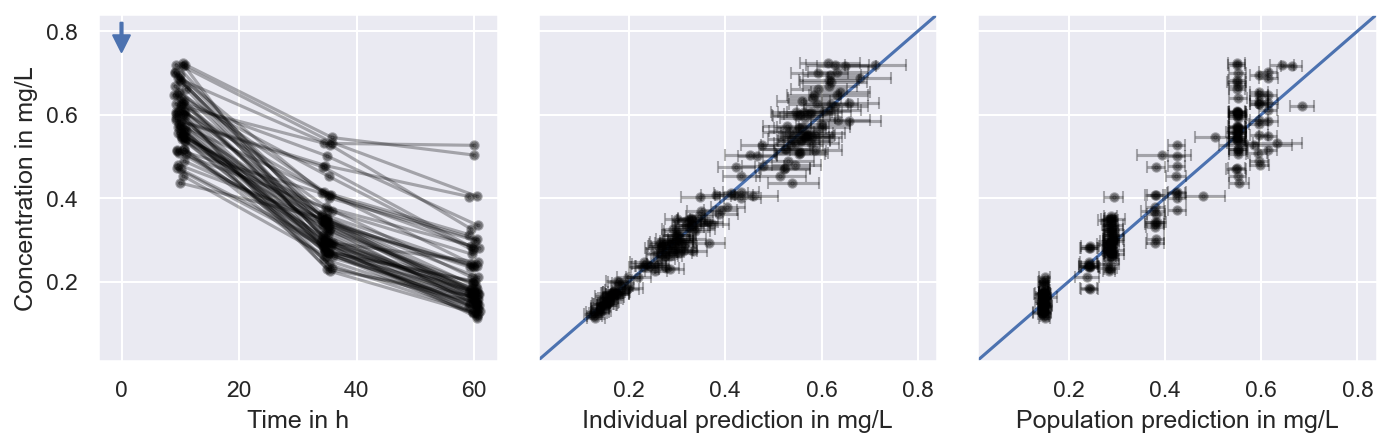

In [122]:
# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

# Visualise measurements
for c in concs:
    jitter = np.random.uniform(-1, 1, size=len(times))
    axes[0].plot(
        times + jitter, c, marker='o', color='black',
        alpha=0.3, markersize=4)
    axes[0].scatter(
        times + jitter, c, marker='o', color='black',
        alpha=0.3, s=4)

# Visualise dose point
axes[0].annotate(
    "", xy=(0, 0.75), xytext=(0, 0.82),
    arrowprops=dict(width=1, headwidth=8, headlength=8, color=sns.color_palette()[0]))

# Visualise residuals
axes[1].plot(
    [0, 1], [0, 1], transform=axes[1].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits, axis=0)
fifth = medians - np.percentile(indiv_fits, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[1].errorbar(
        f, concs[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[1].scatter(
        f, concs[idf], marker='o', color='black', alpha=0.3, s=4)

# axes[2].plot(
#     [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
# medians = np.median(pop_fits, axis=0)
# fifth = medians - np.percentile(pop_fits, axis=0, q=5)
# ninetyfifth = np.percentile(pop_fits, axis=0, q=95) - medians
# for c in concs:
#     axes[2].errorbar(
#         medians, c, marker='o', color='black', alpha=0.3, ls='none',
#         xerr=np.vstack((fifth[np.newaxis, :], ninetyfifth[np.newaxis, :])),
#         capsize=3, markersize=4)
#     axes[2].scatter(
#         medians, c, marker='o', color='black', alpha=0.3, s=4)
axes[2].plot(
    [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits, axis=0)
fifth = medians - np.percentile(pop_fits, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[2].errorbar(
        f, concs[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[2].scatter(
        f, concs[idf], marker='o', color='black', alpha=0.3, s=4)

# Label axes
axes[0].set_xlabel('Time in h')
axes[0].set_ylabel('Concentration in mg/L')
axes[1].set_xlabel('Individual prediction in mg/L')
axes[1].set_ylabel('')
axes[2].set_xlabel('Population prediction in mg/L')
axes[2].set_ylabel('')
axes[0].set_xlim([-4, 64])
axes[1].set_ylim([0.01, 0.84])
axes[1].set_xlim([0.01, 0.84])
axes[2].set_ylim([0.01, 0.84])
axes[2].set_xlim([0.01, 0.84])

plt.show()

Covariate summary

In [108]:
print('Fraction with *1/*1: ', np.sum(covariates[:, 0] == 0) / len(covariates))
print('Fraction with *1/*2: ', np.sum(covariates[:, 0] == 1) / len(covariates))
print('Fraction with *1/*3: ', np.sum(covariates[:, 0] == 2) / len(covariates))
print('Fraction with *2/*2: ', np.sum(covariates[:, 0] == 3) / len(covariates))
print('Fraction with *2/*3: ', np.sum(covariates[:, 0] == 4) / len(covariates))
print('Fraction with *3/*3: ', np.sum(covariates[:, 0] == 5) / len(covariates))
print(
    'Age: %.0f (%.0f - %.0f)' % (
        np.median(covariates[:, 1]),
        np.percentile(covariates[:, 1], q=5),
        np.percentile(covariates[:, 1], q=95)))

Fraction with *1/*1:  0.6166666666666667
Fraction with *1/*2:  0.2
Fraction with *1/*3:  0.13333333333333333
Fraction with *2/*2:  0.016666666666666666
Fraction with *2/*3:  0.016666666666666666
Fraction with *3/*3:  0.016666666666666666
Age: 69 (58 - 79)
